In this project, we will explore Seattle AirBnB dataset with [CRISP-DM](https://www.datascience-pm.com/crisp-dm-2/)

CRSIP-DM follow 6 step:
1. Business understanding
2. Data understanding
3. Prepare data
4. Model data
5. Evaluation results
6. Deployment

## Business Understanding

[Airbnb](https://en.wikipedia.org/wiki/Airbnb) is an online marketplace for lodging, primarily homestays for vacation rental and tourism activities in the US since 2008. The business runs on customer data and requires analysis to fast growth and more user engagement. Airbnb has been public their data for Seattle on [Kaggle](https://www.kaggle.com/datasets/airbnb/seattle?resource=download) for data analysis.

This notebook using Seattle Kaggle data to answer these questions:
1. How Airbnb prices change by time (week, month)?
2. What are the factors that impact price of a house on Airbnb?
3. What factors impact user's experiences ?
4. How to set your Airbnb price?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.parsing import remove_stopwords, strip_punctuation
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

calendar = pd.read_csv("data/calendar.csv")
listings = pd.read_csv("data/listings.csv")
reviews = pd.read_csv("data/reviews.csv")

## calendar.csv

In [2]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [3]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In calendar.csv has 4 columns and we can see some characteristics of the data.
* `listing_id` contains id of room in AirBnB
* Only column `price` contains null value
* `date` has string type and contains with format `yyyy-mm-dd`
* `available` has string type and contains only two values is t and f, maybe it's mean True and False
* `price` has string type and has format `$x,xxx.xx`

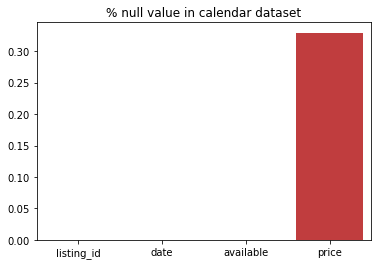

In [4]:
calendar_null_per = calendar.isnull().sum() / len(calendar)
sns.barplot(x=calendar_null_per.index, y=calendar_null_per.values).set_title(
    '% null value in calendar dataset')
plt.show()

In [5]:
calendar.available.value_counts(normalize=True)

t    0.67061
f    0.32939
Name: available, dtype: float64

In [6]:
calendar[calendar.available == 'f'].price.isnull().all()

True

* There are 32.94% null values in `price` column.
* If the value in `available` is `f` then the value in `price` is null.

As we can see, only column price is null.

In [7]:
calendar.listing_id.duplicated().any()

True

In [8]:
calendar.listing_id.value_counts().unique()

array([365])

* Each `listing_id` has repeat 365 times. That mean, this is equal to a year
* Calendar.csv provide information about status and price of room within a year.

### Processing data
Before we explore more about calendar, i will do some step to normalize the data. this is:
1. Cast type of column date to datetime.
2. Convert and cast type of price to float.

In [9]:
# function for convert price to float data type
def price_to_float(x):
    return float(x.replace(",", "")[1:])

In [10]:
# cast column date to type datetime
calendar['date'] = pd.to_datetime(calendar.date)
# fill missing values of price columns with default value $0.00
calendar.price.fillna("$0.00", inplace=True)
# cast type of column price to float
calendar['price'] = calendar.price.apply(price_to_float)

calendar.price

0          85.0
1          85.0
2           0.0
3           0.0
4           0.0
           ... 
1393565     0.0
1393566     0.0
1393567     0.0
1393568     0.0
1393569     0.0
Name: price, Length: 1393570, dtype: float64

Let take a look into the average price in dataset

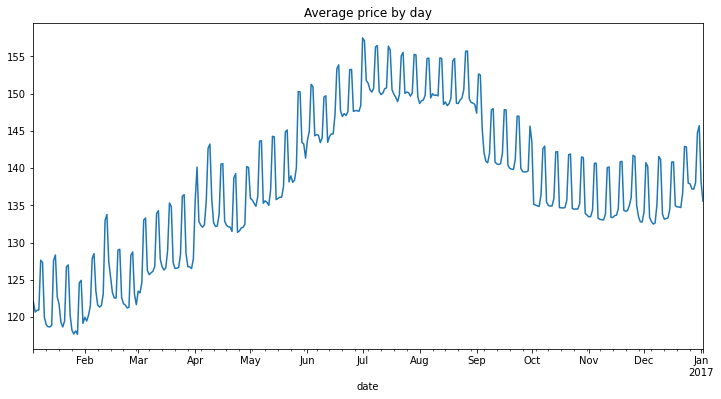

In [11]:
plt.figure(figsize=(12,6))
calendar[calendar.available == 't'].groupby("date").price.mean().plot()
plt.title("Average price by day")
plt.show()

Easy to see that, the average price increase from beginning of the year and peaked in July (increase around 29%, about 35$). 

After that, the price slight decrease. In general, the average price in Seattle Airbnb increase around 17% (20$).

Let take a look into the average price by month and hopefully we can find something different.

In [12]:
calendar['month'] = calendar.date.dt.month_name()
month_summary=calendar[calendar.available == 't'].groupby("month", sort=False).agg({"price": "mean", "available": "count"}).reset_index()

In [13]:
calendar['year'] = calendar.date.dt.year

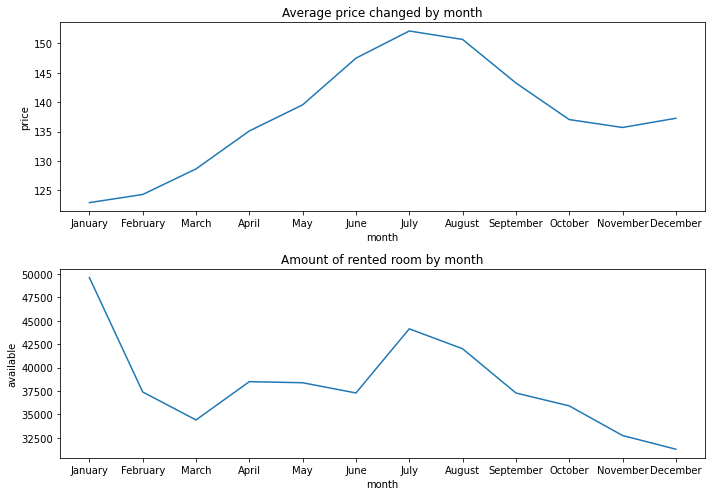

In [14]:
month_price_mean = calendar[calendar.available == 't'].groupby("month", sort=False).price.mean()
month_available = calendar[calendar.available == 'f'].groupby("month", sort=False).available.count()

plt.figure(figsize=(10,7))
ax1 = plt.subplot(211)
sns.lineplot(data=month_price_mean)
ax1.set_title("Average price changed by month")

ax2 = plt.subplot(212)
sns.lineplot(data=month_available)
ax2.set_title("Amount of rented room by month")
plt.tight_layout()
plt.show()

From these 2 chart, we can see:

* From January to March, the numbers of available room and average price both increase
* From March to end of the year, if the numbers of available room decrease, the average price tend to increase and vice versa.
* In July, average price get highest in the year and the numbers of available room is lowest.


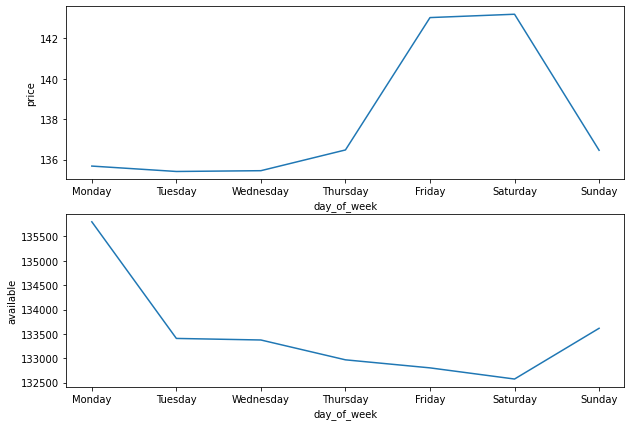

In [15]:
calendar['day_of_week'] = calendar.date.dt.day_name()
dow_avg_price = calendar[calendar.available == 't'].sort_values('date').groupby("day_of_week", sort=False).price.mean()
dow_available = calendar[calendar.available == 't'].sort_values('date').groupby("day_of_week", sort=False).available.count()

plt.figure(figsize=(10,7))
plt.subplot(211)
sns.lineplot(data=dow_avg_price)

plt.subplot(212)
sns.lineplot(data=dow_available)
plt.show()
# sns.lineplot(x=dow_avg_price.index, y=dow_avg_price.values).set_title("Average price by day of week")
# plt.show()

Easy to see that, in the weekend has more people come to Seattle and the average price tend to slightly increase.

So, the answer of the question 1: **How Airbnb room price change by time?** is: 

*From January to March is the time to increase the price of the host. In summer, because a lot of travelers come to Seattle, the number of available room decrease tends to increase the price of the room in Seattle. And the average price of the room in Seattle tends to increase on weekend*.

In [16]:
calendar['day'] = calendar.date.dt.day
avg_price_by_day = calendar.groupby(['month', 'day'], sort=False).price.mean().reset_index()
avg_price_by_day

,month,day,price
0,January,4,55.479047
1,January,5,59.013096
2,January,6,57.835254
3,January,7,56.265846
4,January,8,59.574646
...,...,...,...
360,December,29,102.503667
361,December,30,107.662913
362,December,31,109.101886
363,January,1,105.711629


In [17]:
avg_price_by_day_pivot = avg_price_by_day.pivot(index='day', columns='month', values='price')

In [18]:
# cm = sns.light_palette("green", as_cmap=True)
avg_price_by_day_pivot.describe().style.highlight_max(axis=1, props='color:white; font-weight:bold; background-color:darkblue;')

month,April,August,December,February,January,July,June,March,May,November,October,September
count,30.000000,31.000000,31.000000,29.000000,30.000000,31.000000,30.000000,31.000000,31.000000,30.000000,31.000000,30.000000
mean,89.683700,97.181255,100.958803,82.308439,69.683499,95.377854,99.453597,91.233047,94.281823,96.879911,95.444659,96.612092
std,3.047599,2.165020,3.310875,3.442367,10.556247,1.573077,2.511158,2.960366,3.052293,2.454213,2.384369,2.356608
min,86.376375,93.576742,96.748821,75.823992,55.479047,93.961236,95.250655,86.130959,90.289419,93.920639,93.499214,94.311158
25%,87.727082,95.663829,97.929413,80.119172,64.332635,94.250786,97.136197,89.548324,91.746857,95.066461,93.757858,94.678235
50%,88.324123,96.884756,100.990571,82.586171,70.363934,94.494762,99.833028,90.487428,93.539550,96.139602,94.059455,95.474987
75%,92.090951,98.260084,102.921425,84.668413,72.742994,97.244238,101.066396,93.165925,96.990440,98.969290,98.782478,99.525013
max,99.150079,102.206915,109.101886,87.947355,105.711629,98.015715,104.278680,97.449450,101.398638,102.044264,99.333683,100.731273


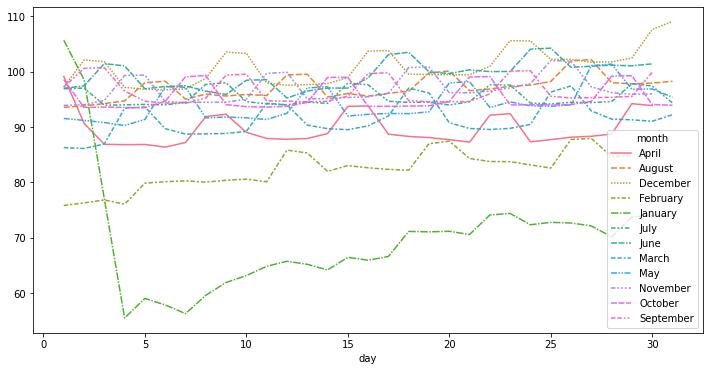

In [19]:
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_price_by_day_pivot)
plt.show()

* It's seem like **December** is the time has **highest** price in the year.
* In **January**, the price has **highest** price volatility.
* in **July** - the most vibrant time in the year, the price has **lowest** price volatility and average price is **highest**.

In [20]:
listing_by_status = calendar.groupby("listing_id").available.value_counts().reset_index(name='count')

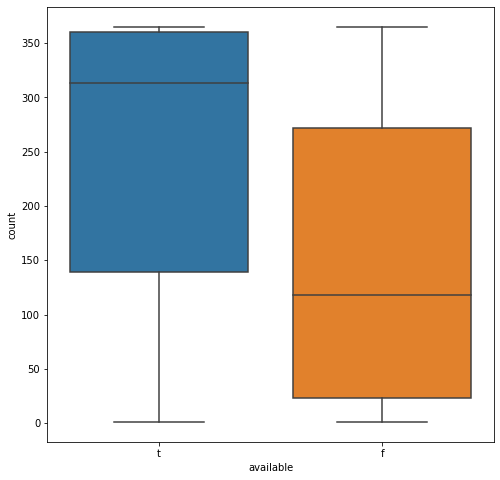

In [21]:
plt.figure(figsize=(8,8))
sns.boxplot(x='available', y='count', data=listing_by_status)
plt.show()

### 1.2 reviews.csv

In [22]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...
...,...,...,...,...,...,...
84844,3624990,50436321,2015-10-12,37419458,Ryan,The description and pictures of the apartment ...
84845,3624990,51024875,2015-10-17,6933252,Linda,We had an excellent stay. It was clean and com...
84846,3624990,51511988,2015-10-20,19543701,Jaime,"Gran ubicación, cerca de todo lo atractivo del..."
84847,3624990,52814482,2015-11-02,24445024,Jørgen,"Very good apartement, clean and well sized. Si..."


In [23]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [24]:
reviews_null = reviews.isnull().sum() / len(reviews)

In [25]:
reviews_null

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.000212
dtype: float64

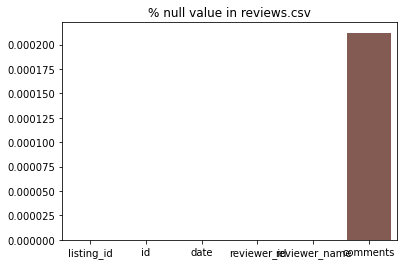

In [26]:
sns.barplot(x=reviews_null.index, y=reviews_null.values).set_title(
    "% null value in reviews.csv")
plt.show()

Only 0.02% of columns `comments` is null. Let explore null rows for considering delete if needed.

In [27]:
reviews[reviews.comments.isnull()]

,listing_id,id,date,reviewer_id,reviewer_name,comments
11034,461567,11614247,2014-04-09,12120141,Abbey,NaN
15383,9460,10563024,2014-02-24,12498029,Debra,NaN
15914,2906694,48629316,2015-09-27,44218980,Anush,NaN
16097,910784,9950520,2014-01-21,179481,Enrico,NaN
27280,10695,52378,2010-06-13,105412,Wei,NaN
29467,1018204,10024984,2014-01-26,10571694,Jordan,NaN
30619,6079216,34824019,2015-06-12,31556342,Mack,NaN
31414,3354614,18103248,2014-08-21,12426758,Jeff,NaN
35210,3554558,24863045,2015-01-03,24488791,Eleanor,NaN
37971,1790020,15640556,2014-07-13,16884291,Michael,NaN


`comments` contains experience of user after use room of host. And only 0.02% of `comments` is null, so we can delete it.

In [28]:
reviews = reviews.dropna().reset_index(drop=True)

In [29]:
reviews['date'] = pd.to_datetime(reviews.date)

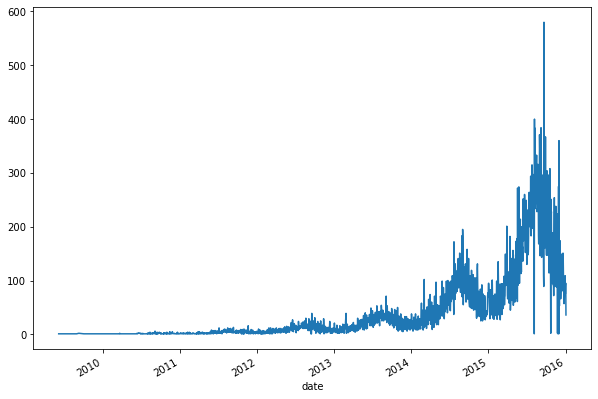

In [30]:
reviews.groupby("date").date.count().plot(figsize=(10,7))

In [31]:
reviews.date.max()

Timestamp('2016-01-03 00:00:00')

The reviews date has wide range from 2009 to 2016. Most of comments come from last year. Let take a look into distribution of reviews for room and the time line of review to more information.

In [32]:
room_count = reviews.listing_id.value_counts()

In [33]:
room_count.describe()

count    3191.000000
mean       26.584456
std        39.832057
min         1.000000
25%         4.000000
50%        13.000000
75%        31.000000
max       474.000000
Name: listing_id, dtype: float64

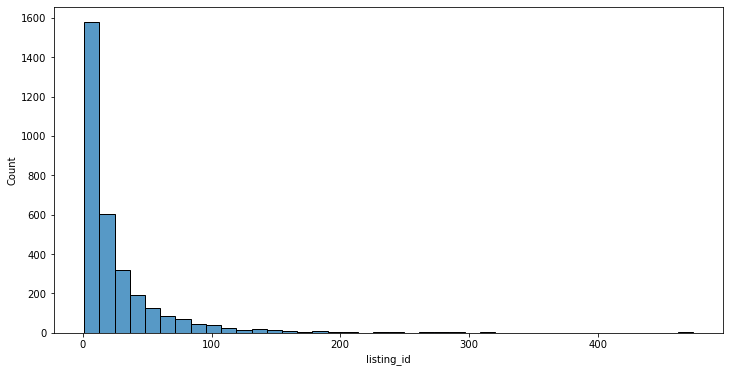

In [34]:
plt.figure(figsize=(12,6))
sns.histplot(room_count, bins=40)

* almost of room have 10 reivews
* Some room have a lot of reviews, let take a look into this room to know more.

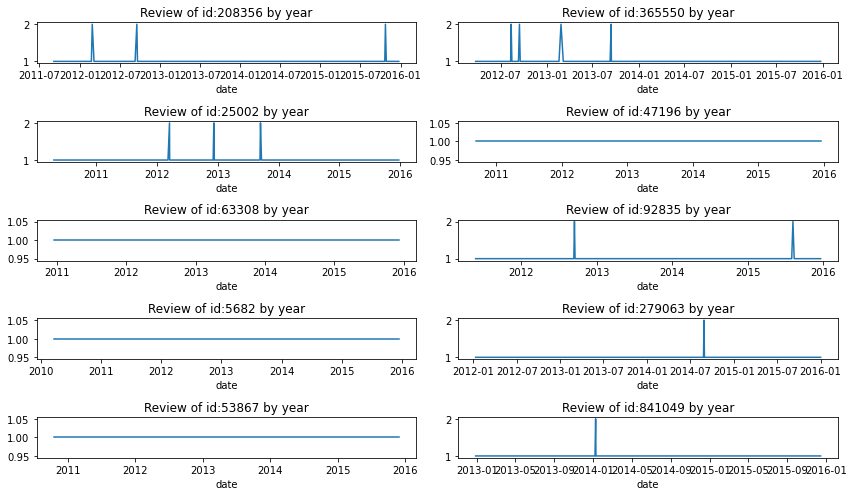

In [35]:
top10_reviews = reviews.listing_id.value_counts().head(10).index
col,row = 2,5
plt.figure(figsize=(12,7))
for i in range(col*row):
    plt.subplot(row,col,i+1)
    d = reviews[reviews.listing_id == top10_reviews[i]].groupby('date').comments.count()
    sns.lineplot(x=d.index, y=d.values, data=d).set_title(f"Review of id:{top10_reviews[i]} by year")
plt.tight_layout()
plt.show()

In top 10 room has most reviews:
* Comment time range is very long (from 2010)
* Always have comment every year

In [36]:
def tokenize_word(s):
    s = s.lower()
    s = remove_stopwords(s)
    s = strip_punctuation(s)
    return s

### listings.csv

In [37]:
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [38]:
listings["accommodates"].value_counts()

2     1627
4      785
3      398
6      332
1      256
5      184
8      119
7       52
10      25
12      15
9       13
16       4
11       3
14       3
15       2
Name: accommodates, dtype: int64

In [39]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                           3641 non-null   object 
 6   space                             3249 non-null   object 
 7   description                       3818 non-null   object 
 8   experiences_offered               3818 non-null   object 
 9   neighborhood_overview             2786 non-null   object 
 10  notes                             2212 non-null   object 
 11  transit                           2884 non-null   object 
 12  thumbn

In [40]:
listings.dtypes.value_counts()

object     62
float64    17
int64      13
dtype: int64

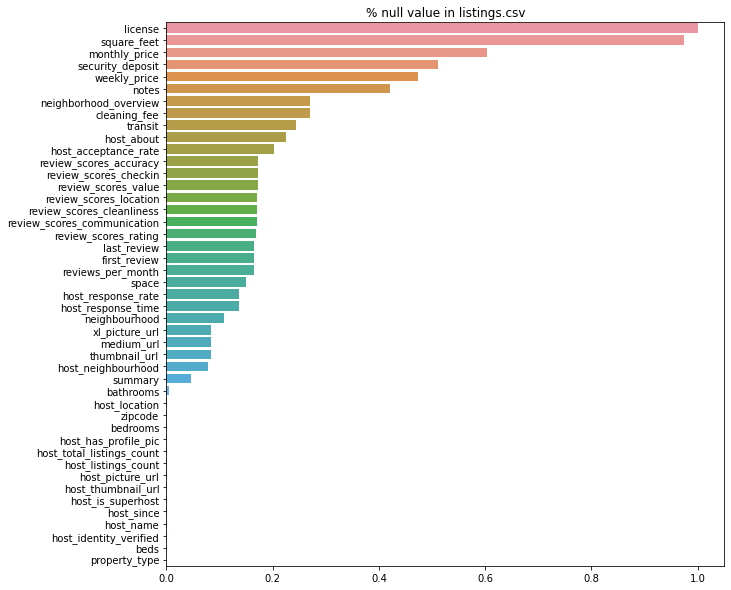

In [41]:
col_missing = listings.columns[listings.isnull().sum() > 0]
plt.figure(figsize=(10,10))
listings_null = (listings[col_missing].isnull().sum() / len(listings)).sort_values(ascending=False)
sns.barplot(x=listings_null.values, y=listings_null.index).set_title(
            "% null value in listings.csv")
# plt.xticks(rotation=90)
plt.show()

Some information about listings
* Contains 92 columns
* 30 columns contains numeric type, anothers has string type.
* Some columns has very high percent of null value (i.e: license - 100%, square_feet - 97%)
* Contains a lot of information related to room: host information, house detail, price, review, address, description...

As we can see that, listings.csv is a *metadata* of house in Airbnb. It contains very detail information about house like: address, host, price, etc.

In the next section, let explore some information about house in metadata and build a model for predict house price by using this information

In [42]:
listings.review_scores_rating.describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

Almost users review and rate very high scores on Airbnb. This means, their has a good experience with home at Airbnb.

In [43]:
listings['price'] = listings.price.apply(price_to_float)

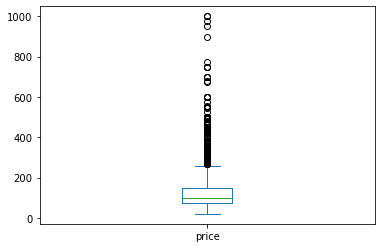

In [44]:
listings.price.plot(kind='box')

About house price in Airbnb:

* Almost of price is under 200 dollar.
* Some of price is higher and highest price reach 1000$ - this is a very very expensive price

In [45]:
negative_id = listings[listings.review_scores_value < 6].id
neg_review = reviews[reviews.listing_id.isin(negative_id)]
neg_review.comments

4203     The apartment itself was totally fine - about ...
43515    Unfortunately my experience with the Belltown ...
53302    Tim was very responsive and clear in his instr...
53303    Tim was a good host and was very responsive to...
72245    I stayed at Vivian's place since it was locate...
78854    TL;DR - This place has a ton of potential, but...
78855    The host canceled this reservation the day bef...
78856    The host canceled this reservation the day bef...
81201    Kevin was an excellent host, both flexible and...
Name: comments, dtype: object

(-0.5, 399.5, 199.5, -0.5)

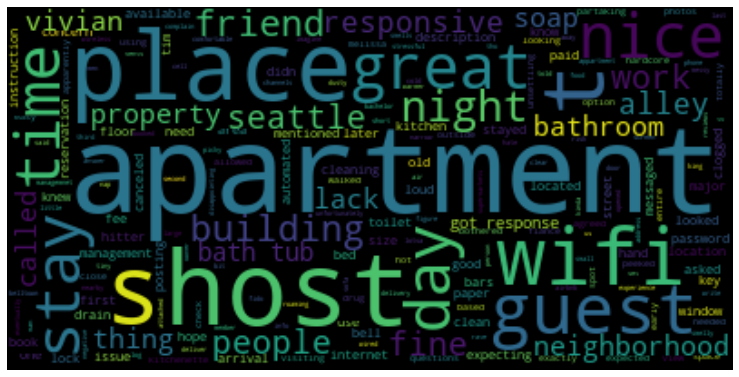

In [46]:
neg_text = neg_review.comments.apply(tokenize_word).tolist()
# text = [tokenize_word(x) for x in text]
neg_wordcloud = WordCloud().generate(" ".join([x for x in neg_text]))
plt.figure(figsize=(13,8))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")

Almost of users give low scores complain about services not reaching their expectations. Some of them are automation reviews. The reason for giving a low score can be the price too expensive, hosts canceled the reservation, information not detailed or extra fee.

In [47]:
top_50 = reviews.listing_id.value_counts().head(100).index
text = reviews[reviews.listing_id.isin(top_50)].comments.apply(tokenize_word).tolist()
# text = [tokenize_word(x) for x in text]
wordcloud = WordCloud().generate(" ".join([x for x in text]))

(-0.5, 399.5, 199.5, -0.5)

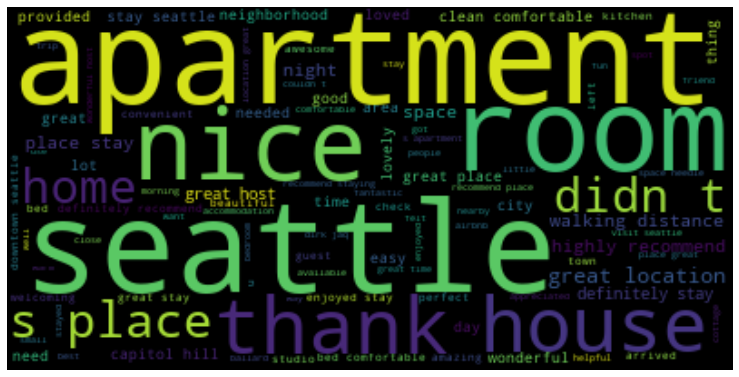

In [48]:
plt.figure(figsize=(13,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Easy to see that, location and type of room are the most important factors that impact to user's experience. besides that, beautiful views, friendly host and clean house is also important to user's experience.

The answer of the questions: **What factors impact users' experiences?**

An apartment with a *great view*, *comfortable*, *nearby downtown*, and *clean* will more attract users. And the *accuracy* and *detailed information* on Airbnb is factors that interested user

In the last session, let build a model that helps predict price of a house and find out what are the factors that impact the price of a house?

In [49]:
feature_cols = ['id','room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price']

In [50]:
df2train = listings[feature_cols].copy().reset_index(drop=True)

In [51]:
df2train = pd.concat([df2train.drop(columns='room_type'),
                      pd.get_dummies(df2train.room_type, prefix="room_type is ", prefix_sep=" ")], axis=1)
df2train = pd.concat([df2train.drop(columns='bed_type'),
                      pd.get_dummies(df2train.bed_type, prefix="bed_type is ", prefix_sep=" ")], axis=1)

In [52]:
df2train = df2train.fillna(0)

In [53]:
train = df2train[[x for x in df2train.columns if x not in ['id', 'price']]]
label = df2train.price

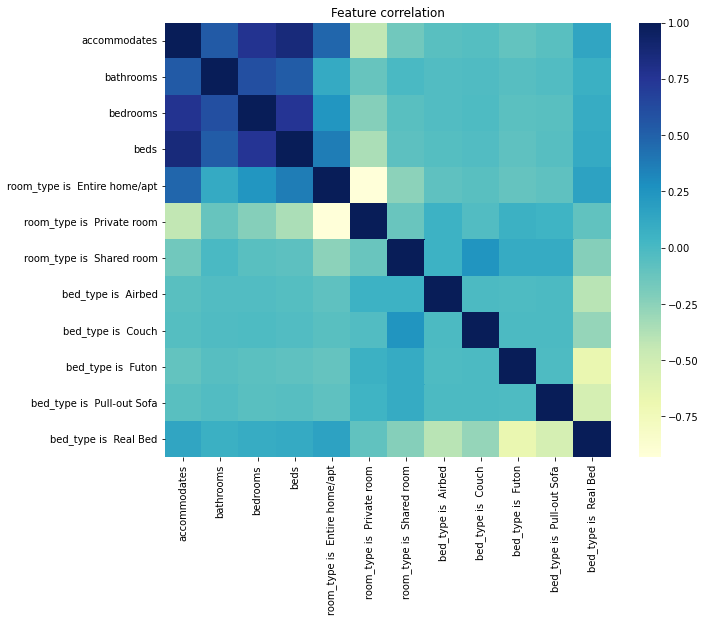

In [54]:
train_corr = train.corr()
plt.figure(figsize=(10,8))
sns.heatmap(data=train_corr, cmap="YlGnBu").set_title("Feature correlation")
plt.show()

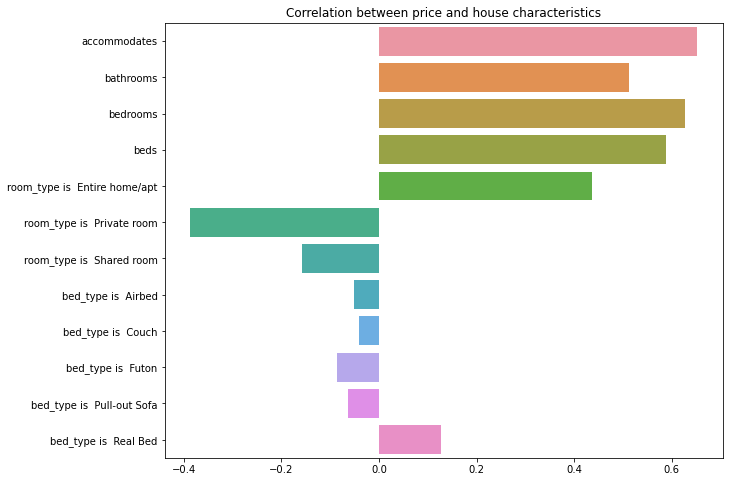

In [55]:
price_vs_feature = train.corrwith(df2train.price)
plt.figure(figsize=(10,8))
sns.barplot(x=price_vs_feature.values, y=price_vs_feature.index).set_title("Correlation between price and house characteristics")
plt.show()

In [56]:
x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.25, random_state=10)

In [57]:
model = LinearRegression()
model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
r2_score(y_test, y_test_pred)

0.562380495580514

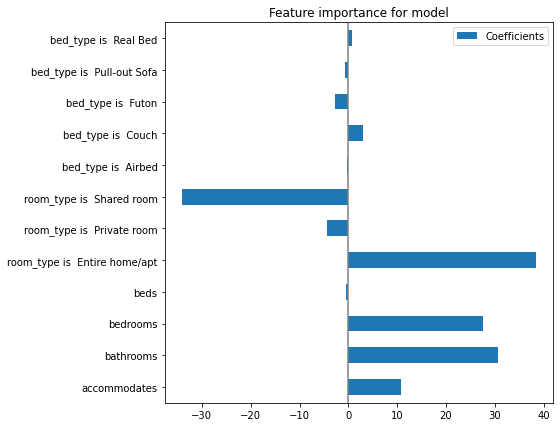

In [58]:
coefs = pd.DataFrame(
   model.coef_,
   columns=['Coefficients'], index=train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature importance for model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The feature `room_type` with value `Entire home/apt` has the highest effect on the model. Otherwise, feature `room_type` with value `Shared room` has the lowest effect. Besides that, `bedrooms` and `bathrooms` are two features that have highly effective to the model.
So, **the type of room, number of bed, and bathrooms** are important features that impact the **price** of the house.

As result above, the answer of the question: **What are the factors that impact price of a house on Airbnb?** is:

Types of room, bedrooms, bathrooms, and the number of people that the house can accommodate are the factors that impact the price of the house. Besides that, as which result of the analysis above, the season and the number of available houses are also factors that impact the price of a house on Airbnb.

In [59]:
listings.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

In [60]:
room_type_mapping = listings.set_index("id").room_type.to_dict()
calendar['room_type'] = calendar.listing_id.map(room_type_mapping)
calendar

,listing_id,date,available,price,month,year,day_of_week,day,room_type
0,241032,2016-01-04,t,85.0,January,2016,Monday,4,Entire home/apt
1,241032,2016-01-05,t,85.0,January,2016,Tuesday,5,Entire home/apt
2,241032,2016-01-06,f,0.0,January,2016,Wednesday,6,Entire home/apt
3,241032,2016-01-07,f,0.0,January,2016,Thursday,7,Entire home/apt
4,241032,2016-01-08,f,0.0,January,2016,Friday,8,Entire home/apt
...,...,...,...,...,...,...,...,...,...
1393565,10208623,2016-12-29,f,0.0,December,2016,Thursday,29,Entire home/apt
1393566,10208623,2016-12-30,f,0.0,December,2016,Friday,30,Entire home/apt
1393567,10208623,2016-12-31,f,0.0,December,2016,Saturday,31,Entire home/apt
1393568,10208623,2017-01-01,f,0.0,January,2017,Sunday,1,Entire home/apt


In [61]:
room_type_by_month = calendar[calendar.available == 'f'].groupby(["month"], sort=False).room_type.value_counts().reset_index(name='count')
room_type_pivot = room_type_by_month.pivot(index='month', columns='room_type', values='count')
room_type_pivot

room_type,Entire home/apt,Private room,Shared room
month,,,
April,27843,9994,666
August,30326,10972,713
December,22484,8261,552
February,28214,8643,544
January,36139,12494,970
July,31966,11415,755
June,27093,9539,664
March,26430,7457,533
May,27774,9919,694


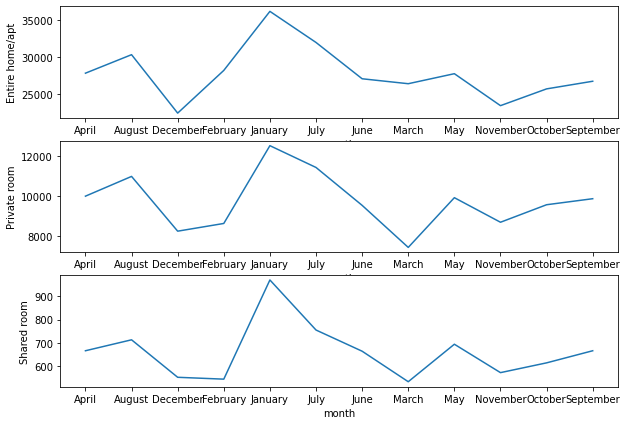

In [62]:
plt.figure(figsize=(10,7))
plt.subplot(311)
sns.lineplot(data=room_type_pivot['Entire home/apt'])

plt.subplot(312)
sns.lineplot(data=room_type_pivot['Private room'])

plt.subplot(313)
sns.lineplot(data=room_type_pivot['Shared room'])

plt.show()

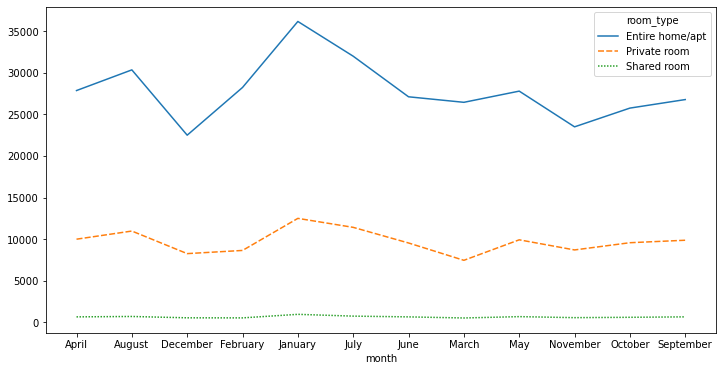

In [63]:
plt.figure(figsize=(12,6))
sns.lineplot(data=room_type_pivot)
plt.show()

## Conclusion

In this session, I will summarize the results of 3 questions and answer the last question: **how to set your Airbnb price?**
1. On Airbnb, price changed over time
2. There are many factors that impact to price of the house with type of room, bathroom, bed, bedroom are most important
3. User want to find a room with beautiful view and nearby downtown and if you have any extra fees, it's good for you to write them down.
